In [20]:
import numpy as np
import numpy.ma as ma # Numpy mask
import rasterio as rio

nodata = 0 # What pixel value do we want to mask?

# Max and min target values for uint16 histograms
L = 0 # output minimum
H = 65535 # output maximum
E = int(65535/2) # output mean

target_WV3_file = 'sample/subscene_nd_asdefault.tif'
output_WV3_file = 'sample/subscene_nd_asdefault_BCET.tif'

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 1283, 'height': 1651, 'count': 8, 'crs': CRS.from_epsg(32719), 'transform': Affine(1.2055985069611754, 0.0, 772580.3999999999,
       0.0, -1.2054674493996196, 6987841.396092175), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


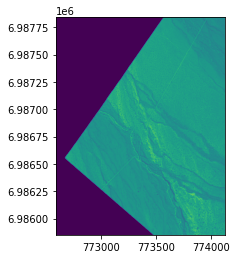

<AxesSubplot:>

In [21]:
# Load image into memory

wv3_src = rio.open(target_WV3_file, 'r')
wv3_profile = wv3_src.profile
print(wv3_profile)

from rasterio.plot import show
show(wv3_src)


In [22]:

# Create new geotiff with BCET-ed layers

wv3_profile.update({'nodata':nodata}) # Update metadata with chosen nodata value
    
with rio.open(output_WV3_file, 'w', **wv3_profile) as wv3_bcet:
    
    # Loop through each bands
    for layer_n in range(0,wv3_profile['count']):

        # Read band
        dat = wv3_src.read(layer_n+1)
        
        ### ADD NODATA MASK ###
        nodata_array = np.full(dat.shape, nodata) # A dummy array that just contains nodata values
        mask = np.equal(dat, nodata_array) # A bitwise mask of what parts of our original data match nodata
        dat_masked = ma.array(dat, mask=mask) # Mask out nodata values so our BCET algorithm ignores them
        
        ### BCET ###
        
        s = np.mean(np.power(dat_masked,2)) # mean squared
        e = np.mean(dat_masked)
        l = np.min(dat_masked)
        h = np.max(dat_masked)

        # Find b
        b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
        b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

        b = b_nom/b_den

        # Find a
        a1 = H-L
        a2 = h-l
        a3 = h+l-(2*b)

        a = a1/(a2*a3)

        # Find c
        c = L-(a*(l-b)**2)

        # Process raster
        bcet_raster = a*((dat_masked - b)**2) + c
    
        # Write layer to output file
        wv3_bcet.write(bcet_raster.astype(np.uint16), layer_n+1)
        

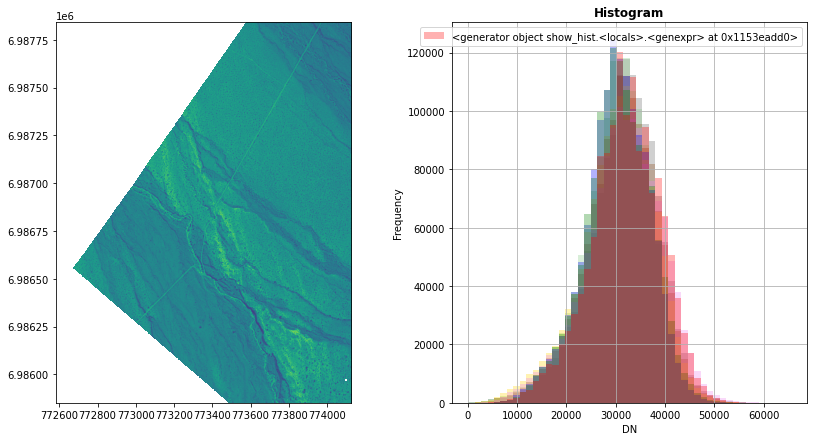

In [23]:
# Plot BCET band histograms

from rasterio.plot import show_hist
import matplotlib.pyplot as plt

with rio.open(output_WV3_file) as src:
    fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled',
              lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    plt.show()